

🎯 DEEPFAKE DETECTION MODEL TRAINING
Using REAL datasets: DFDC, FaceForensics++, Celeb-DF

📂 Step 1: Loading Dataset...
✅ Found processed data file!
✅ DatasetLoader initialized (img_size=224, max_samples=10000)
   Loading MTCNN face detector...



   ✅ MTCNN loaded!

📂 Loading processed data from processed_data.npz...
✅ Data loaded successfully!

📊 Step 2: Splitting Dataset...
✅ Split complete!
   Training:   2,100
   Validation: 450
   Test:       450

🏗️  Step 3: Building Model...

🏗️  BUILDING MODEL

✅ Model built successfully!
   Total parameters: 18,723,424

🚀 Step 4: Training Model...

🚀 STARTING TRAINING
Training samples: 2100
Validation samples: 450
Epoch 1/50

132/132 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.6333 - precision: 0.6415 - recall: 0.9718
Epoch 1: val_accuracy improved from -inf to 0.64222, saving model to models\deepfake_detector_best.h5


C:\Users\Ayush\.conda\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


132/132 [==============================] - 254s 2s/step - loss: 0.6631 - accuracy: 0.6333 - precision: 0.6415 - recall: 0.9718 - val_loss: 0.6557 - val_accuracy: 0.6422 - val_precision: 0.6422 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 2/50
132/132 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.6386 - precision: 0.6429 - recall: 0.9829
Epoch 2: val_accuracy did not improve from 0.64222
132/132 [==============================] - 220s 2s/step - loss: 0.6592 - accuracy: 0.6386 - precision: 0.6429 - recall: 0.9829 - val_loss: 0.6590 - val_accuracy: 0.6422 - val_precision: 0.6422 - val_recall: 1.0000 - lr: 1.0000e-04
Epoch 3/50
132/132 [==============================] - ETA: 0s - loss: 0.6631 - accuracy: 0.6310 - precision: 0.6394 - recall: 0.9748
Epoch 3: val_accuracy did not improve from 0.64222
132/132 [==============================] - 246s 2s/step - loss: 0.6631 - accuracy: 0.6310 - precision: 0.6394 - recall: 0.9748 - val_loss: 0.6510 - val_accuracy: 0.6422 -

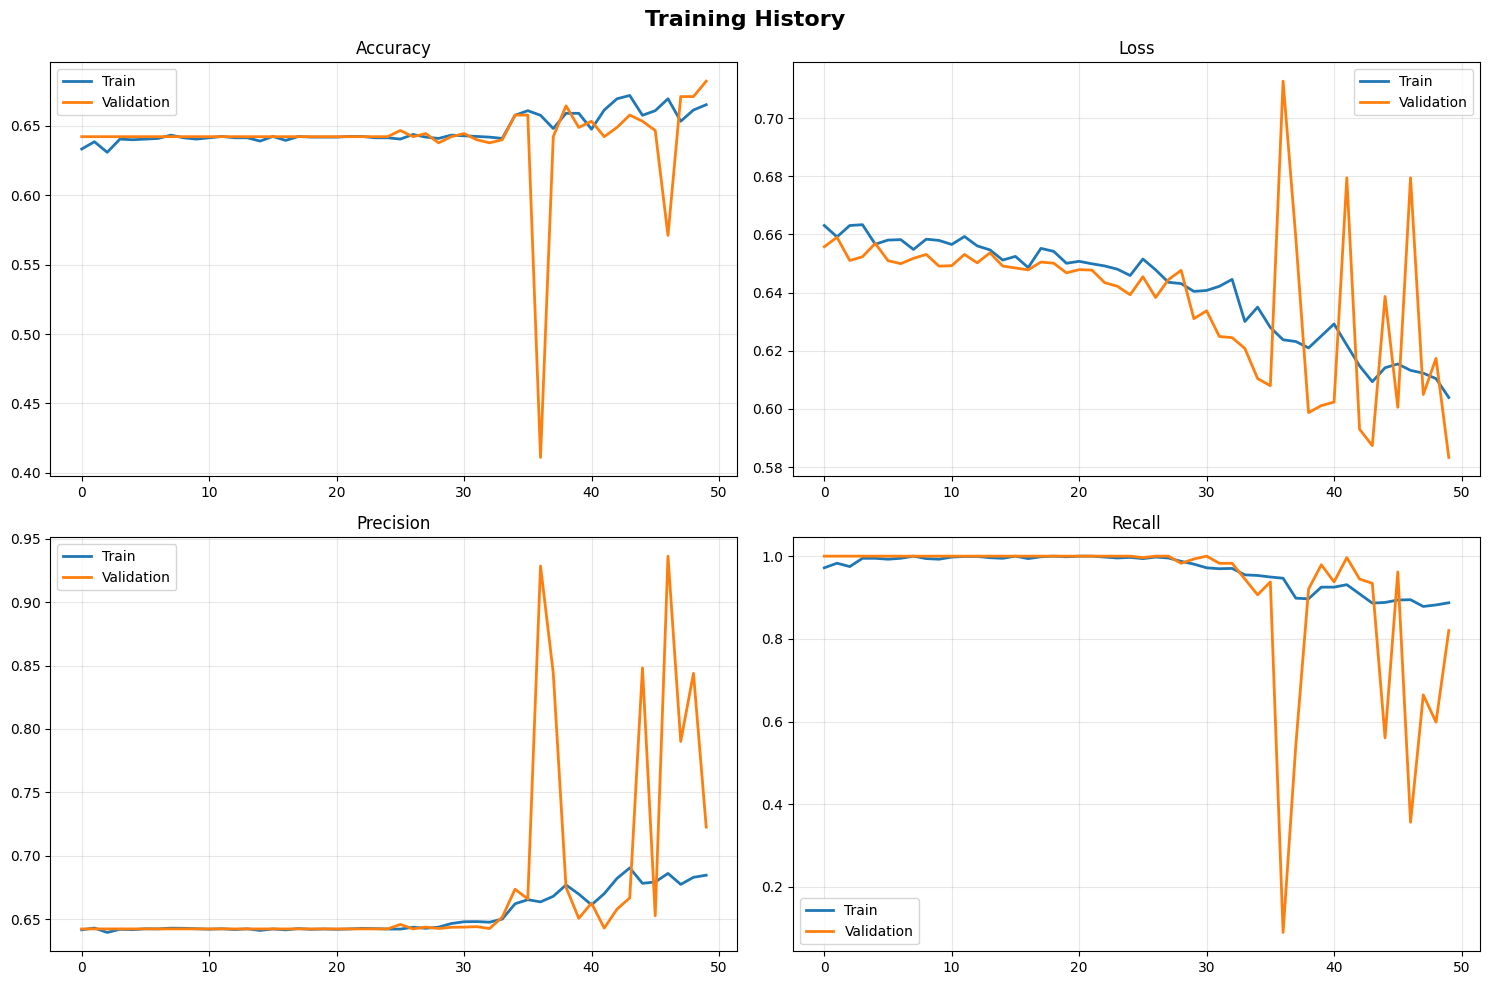

✅ Confusion matrix saved!


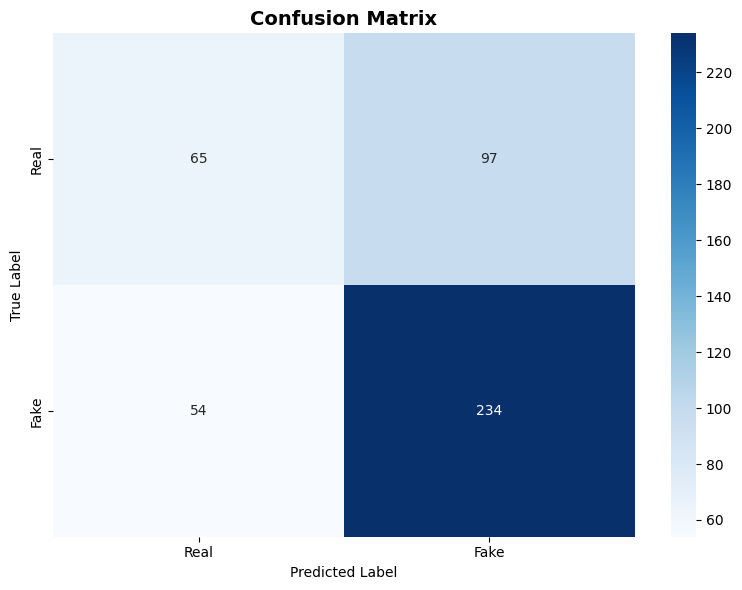


💾 Step 7: Saving Final Model...


C:\Users\Ayush\.conda\envs\tf\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Model saved!

✅ TRAINING COMPLETE!

🎉 You can now use this model for deepfake detection!


In [1]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from mtcnn import MTCNN
# ============================================================================
# CONFIGURATION
# ============================================================================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.0001
# Dataset paths - UPDATE THESE WITH YOUR ACTUAL PATHS
DATASET_PATHS = {
    'dfdc': r"D:\datasets\dfdc dataset\dfdc_train_part_00\dfdc_train_part_0",
    'faceforensics': r"D:\datasets\faceforensics\FaceForensics++_C23",
    'celebdf': r"D:\datasets\celeb-df\Celeb-DF-v2"
}
MAX_SAMPLES = 1000  # Use 1000 for quick testing, 10000+ for production
# ============================================================================
# DATASET LOADER CLASS
# ============================================================================
class DatasetLoader:
    """Load and process DFDC, FaceForensics++, and Celeb-DF datasets"""
    
    def __init__(self, img_size=224, max_samples_per_dataset=10000):
        self.img_size = img_size
        self.max_samples = max_samples_per_dataset
        print(f"✅ DatasetLoader initialized (img_size={img_size}, max_samples={max_samples_per_dataset})")
        print("   Loading MTCNN face detector...")
        self.face_detector = MTCNN()
        print("   ✅ MTCNN loaded!")
        
    def extract_face(self, image):
        """Extract and resize face from image"""
        try:
            if len(image.shape) == 2:
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            elif image.shape[2] == 4:
                image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
            
            faces = self.face_detector.detect_faces(image)
            
            if len(faces) > 0:
                face = max(faces, key=lambda x: x['box'][2] * x['box'][3])
                x, y, w, h = face['box']
                
                padding = 20
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(image.shape[1] - x, w + 2 * padding)
                h = min(image.shape[0] - y, h + 2 * padding)
                
                face_img = image[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (self.img_size, self.img_size))
                return face_img
            return None
        except:
            return None
    
    def extract_frames_from_video(self, video_path, num_frames=10):
        """Extract evenly spaced frames from video"""
        frames = []
        try:
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if total_frames == 0:
                cap.release()
                return frames
            
            frame_indices = np.linspace(0, total_frames - 1, min(num_frames, total_frames), dtype=int)
            
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
            
            cap.release()
        except:
            pass
        
        return frames
    
    def load_dfdc_dataset(self, dfdc_path):
        """Load DFDC Dataset - FLEXIBLE VERSION"""
        print("\n" + "="*70)
        print("📊 LOADING DFDC DATASET")
        print("="*70)
        print(f"Path: {dfdc_path}")
        
        images = []
        labels = []
        count = 0
        
        if not os.path.exists(dfdc_path):
            print(f"❌ Path does not exist: {dfdc_path}")
            return np.array([]), np.array([])
        
        print(f"✅ Path exists!")
        
        # Check if we're pointing directly to a train part folder
        metadata_path_direct = os.path.join(dfdc_path, 'metadata.json')
        
        if os.path.exists(metadata_path_direct):
            # CASE 1: Direct path to a train part folder
            print(f"✅ Found metadata.json directly in: {dfdc_path}")
            print("📁 Processing single train part folder...")
            
            with open(metadata_path_direct, 'r') as f:
                metadata = json.load(f)
            
            print(f"📹 Found {len(metadata)} videos in metadata")
            
            for video_name, video_info in tqdm(metadata.items(), desc="Processing DFDC videos"):
                if count >= self.max_samples:
                    break
                
                video_path = os.path.join(dfdc_path, video_name)
                
                if not os.path.exists(video_path):
                    continue
                
                label = 0 if video_info['label'] == 'REAL' else 1
                frames = self.extract_frames_from_video(video_path, num_frames=5)
                
                for frame in frames:
                    if count >= self.max_samples:
                        break
                    
                    face = self.extract_face(frame)
                    if face is not None:
                        images.append(face)
                        labels.append(label)
                        count += 1
        
        else:
            # CASE 2: Standard structure with train/ folder
            train_path = os.path.join(dfdc_path, 'train')
            
            if not os.path.exists(train_path):
                print(f"❌ Neither metadata.json nor train/ folder found")
                return np.array([]), np.array([])
            
            print(f"✅ Found train folder at: {train_path}")
            part_folders = [f for f in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, f))]
            print(f"📁 Found {len(part_folders)} part folders")
            
            for part_folder in part_folders:
                if count >= self.max_samples:
                    break
                    
                part_path = os.path.join(train_path, part_folder)
                metadata_path = os.path.join(part_path, 'metadata.json')
                
                if not os.path.exists(metadata_path):
                    continue
                
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                
                print(f"\n📁 Processing {part_folder} ({len(metadata)} videos)...")
                
                for video_name, video_info in tqdm(metadata.items(), desc=f"{part_folder}"):
                    if count >= self.max_samples:
                        break
                    
                    video_path = os.path.join(part_path, video_name)
                    
                    if not os.path.exists(video_path):
                        continue
                    
                    label = 0 if video_info['label'] == 'REAL' else 1
                    frames = self.extract_frames_from_video(video_path, num_frames=5)
                    
                    for frame in frames:
                        if count >= self.max_samples:
                            break
                        
                        face = self.extract_face(frame)
                        if face is not None:
                            images.append(face)
                            labels.append(label)
                            count += 1
        
        print(f"\n" + "="*70)
        print(f"✅ TOTAL LOADED FROM DFDC: {len(images)} images")
        if len(images) > 0:
            print(f"   Real: {np.sum(np.array(labels) == 0)}")
            print(f"   Fake: {np.sum(np.array(labels) == 1)}")
        print("="*70)
        
        return np.array(images), np.array(labels)
    
    def load_faceforensics_dataset(self, ff_path):
        """Load FaceForensics++ Dataset - FLAT STRUCTURE"""
        print("\n" + "="*70)
        print("📊 LOADING FACEFORENSICS++ DATASET")
        print("="*70)
        
        images = []
        labels = []
        
        if not os.path.exists(ff_path):
            print(f"❌ FaceForensics++ folder not found at: {ff_path}")
            return np.array([]), np.array([])
        
        print(f"✅ FaceForensics++ folder found at: {ff_path}")
        folder_contents = os.listdir(ff_path)
        print(f"📂 Folder contents: {folder_contents}")
        
        has_original = 'original' in folder_contents
        
        if has_original:
            print("✅ Detected FLAT structure with 'original' folder")
            
            # Load REAL videos
            real_path = os.path.join(ff_path, 'original')
            real_count = 0
            
            if os.path.exists(real_path):
                video_files = [f for f in os.listdir(real_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                print(f"\n📁 Found {len(video_files)} REAL videos")
                
                if len(video_files) > 0:
                    print("⏳ Processing REAL videos...")
                    for video_name in tqdm(video_files[:self.max_samples//2], desc="Real videos"):
                        if real_count >= self.max_samples // 2:
                            break
                        
                        video_path = os.path.join(real_path, video_name)
                        frames = self.extract_frames_from_video(video_path, num_frames=3)
                        
                        for frame in frames:
                            if real_count >= self.max_samples // 2:
                                break
                            face = self.extract_face(frame)
                            if face is not None:
                                images.append(face)
                                labels.append(0)
                                real_count += 1
                    
                    print(f"✅ Extracted {real_count} real samples")
            
            # Load FAKE videos
            fake_methods = ['Deepfakes', 'DeepFakes', 'Face2Face', 'FaceSwap', 'NeuralTextures', 'FaceShifter', 'DeepFakeDetection']
            fake_count = 0
            
            for method in fake_methods:
                method_path = os.path.join(ff_path, method)
                
                if not os.path.exists(method_path):
                    continue
                
                video_files = [f for f in os.listdir(method_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                
                if len(video_files) == 0:
                    subfolders = [f for f in os.listdir(method_path) if os.path.isdir(os.path.join(method_path, f))]
                    if subfolders:
                        method_path = os.path.join(method_path, subfolders[0])
                        video_files = [f for f in os.listdir(method_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                
                if len(video_files) == 0:
                    continue
                
                print(f"\n📁 Found {len(video_files)} {method} videos")
                
                for video_name in tqdm(video_files[:self.max_samples//10], desc=f"{method}"):
                    if fake_count >= self.max_samples // 2:
                        break
                    
                    video_path = os.path.join(method_path, video_name)
                    frames = self.extract_frames_from_video(video_path, num_frames=3)
                    
                    for frame in frames:
                        if fake_count >= self.max_samples // 2:
                            break
                        face = self.extract_face(frame)
                        if face is not None:
                            images.append(face)
                            labels.append(1)
                            fake_count += 1
        
        print(f"\n" + "="*70)
        print(f"✅ TOTAL LOADED FROM FACEFORENSICS++: {len(images)} images")
        if len(images) > 0:
            print(f"   Real: {np.sum(np.array(labels) == 0)}")
            print(f"   Fake: {np.sum(np.array(labels) == 1)}")
        print("="*70)
        
        return np.array(images), np.array(labels)
    
    def load_celebdf_dataset(self, celebdf_path):
        """Load Celeb-DF Dataset"""
        print("\n" + "="*70)
        print("📊 LOADING CELEB-DF DATASET")
        print("="*70)
        
        images = []
        labels = []
        
        if not os.path.exists(celebdf_path):
            print(f"❌ Celeb-DF folder not found at: {celebdf_path}")
            return np.array([]), np.array([])
        
        # Load real videos
        real_path = os.path.join(celebdf_path, 'Celeb-real')
        real_count = 0
        
        if os.path.exists(real_path):
            video_files = [f for f in os.listdir(real_path) if f.endswith('.mp4')]
            print(f"\n📁 Found {len(video_files)} REAL videos")
            
            for video_name in tqdm(video_files[:self.max_samples//2], desc="Real videos"):
                if real_count >= self.max_samples // 2:
                    break
                
                video_path = os.path.join(real_path, video_name)
                frames = self.extract_frames_from_video(video_path, num_frames=5)
                
                for frame in frames:
                    if real_count >= self.max_samples // 2:
                        break
                    face = self.extract_face(frame)
                    if face is not None:
                        images.append(face)
                        labels.append(0)
                        real_count += 1
        
        # Load fake videos
        fake_path = os.path.join(celebdf_path, 'Celeb-synthesis')
        fake_count = 0
        
        if os.path.exists(fake_path):
            video_files = [f for f in os.listdir(fake_path) if f.endswith('.mp4')]
            print(f"\n📁 Found {len(video_files)} FAKE videos")
            
            for video_name in tqdm(video_files[:self.max_samples//2], desc="Fake videos"):
                if fake_count >= self.max_samples // 2:
                    break
                
                video_path = os.path.join(fake_path, video_name)
                frames = self.extract_frames_from_video(video_path, num_frames=5)
                
                for frame in frames:
                    if fake_count >= self.max_samples // 2:
                        break
                    face = self.extract_face(frame)
                    if face is not None:
                        images.append(face)
                        labels.append(1)
                        fake_count += 1
        
        print(f"\n" + "="*70)
        print(f"✅ TOTAL LOADED FROM CELEB-DF: {len(images)} images")
        if len(images) > 0:
            print(f"   Real: {np.sum(np.array(labels) == 0)}")
            print(f"   Fake: {np.sum(np.array(labels) == 1)}")
        print("="*70)
        
        return np.array(images), np.array(labels)
    
    def load_all_datasets(self, dataset_paths):
        """Load all datasets and combine them"""
        all_images = []
        all_labels = []
        
        print("\n" + "="*70)
        print("🚀 STARTING DATASET LOADING")
        print("="*70)
        
        # Load DFDC
        if 'dfdc' in dataset_paths and dataset_paths['dfdc']:
            images, labels = self.load_dfdc_dataset(dataset_paths['dfdc'])
            if len(images) > 0:
                all_images.append(images)
                all_labels.append(labels)
        
        # Load FaceForensics++
        if 'faceforensics' in dataset_paths and dataset_paths['faceforensics']:
            images, labels = self.load_faceforensics_dataset(dataset_paths['faceforensics'])
            if len(images) > 0:
                all_images.append(images)
                all_labels.append(labels)
        
        # Load Celeb-DF
        if 'celebdf' in dataset_paths and dataset_paths['celebdf']:
            images, labels = self.load_celebdf_dataset(dataset_paths['celebdf'])
            if len(images) > 0:
                all_images.append(images)
                all_labels.append(labels)
        
        if len(all_images) == 0:
            print("\n❌ No datasets loaded!")
            return None, None
        
        # Combine all datasets
        print("\n" + "="*70)
        print("🔗 COMBINING DATASETS")
        print("="*70)
        
        X = np.concatenate(all_images, axis=0)
        y = np.concatenate(all_labels, axis=0)
        
        # Normalize
        X = X.astype('float32') / 255.0
        
        print(f"\n✅ TOTAL DATASET SIZE: {len(X)} images")
        print(f"   Real: {np.sum(y == 0)} ({100*np.sum(y==0)/len(y):.1f}%)")
        print(f"   Fake: {np.sum(y == 1)} ({100*np.sum(y==1)/len(y):.1f}%)")
        print("="*70)
        
        return X, y
    
    def save_processed_data(self, X, y, filename='processed_data.npz'):
        """Save processed data to disk"""
        print(f"\n💾 Saving processed data to {filename}...")
        np.savez_compressed(filename, X=X, y=y)
        file_size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"✅ Saved! File size: {file_size_mb:.1f} MB")
    
    def load_processed_data(self, filename='processed_data.npz'):
        """Load processed data from disk"""
        print(f"\n📂 Loading processed data from {filename}...")
        data = np.load(filename)
        print("✅ Data loaded successfully!")
        return data['X'], data['y']
# ============================================================================
# DEEPFAKE DETECTOR CLASS
# ============================================================================
class DeepFakeDetector:
    """DeepFake Detection Model using EfficientNet-B4"""
    
    def __init__(self, img_size=224):
        self.img_size = img_size
        self.model = None
        
    def build_model(self):
        """Build EfficientNet-B4 based model"""
        print("\n" + "="*70)
        print("🏗️  BUILDING MODEL")
        print("="*70)
        
        input_layer = Input(shape=(self.img_size, self.img_size, 3))
        
        base_model = EfficientNetB4(
            include_top=False,
            weights='imagenet',
            input_tensor=input_layer,
            pooling=None
        )
        
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        
        x = base_model.output
        x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
        x = Dense(512, activation='relu', name='fc1')(x)
        x = Dropout(0.5, name='dropout1')(x)
        x = Dense(256, activation='relu', name='fc2')(x)
        x = Dropout(0.3, name='dropout2')(x)
        output = Dense(1, activation='sigmoid', name='output')(x)
        
        self.model = Model(inputs=input_layer, outputs=output, name='DeepFake_Detector')
        
        self.model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )
        
        print(f"\n✅ Model built successfully!")
        print(f"   Total parameters: {self.model.count_params():,}")
        
        return self.model
    
    def train(self, X_train, y_train, X_val, y_val):
        """Train the model"""
        print("\n" + "="*70)
        print("🚀 STARTING TRAINING")
        print("="*70)
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        
        os.makedirs('models', exist_ok=True)
        os.makedirs('results', exist_ok=True)
        
        callbacks = [
            ModelCheckpoint(
                'models/deepfake_detector_best.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            )
        ]
        
        history = self.model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )
        
        return history
    
    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        print("\n" + "="*70)
        print("📊 EVALUATING MODEL")
        print("="*70)
        
        y_pred_proba = self.model.predict(X_test, verbose=1)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        
        print("\n📊 Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))
        
        cm = confusion_matrix(y_test, y_pred)
        print("\n📋 Confusion Matrix:")
        print(cm)
        
        tn, fp, fn, tp = cm.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        auc = roc_auc_score(y_test, y_pred_proba)
        
        print("\n✅ Performance Summary:")
        print(f"   Accuracy:  {accuracy*100:.2f}%")
        print(f"   Precision: {precision*100:.2f}%")
        print(f"   Recall:    {recall*100:.2f}%")
        print(f"   F1-Score:  {f1*100:.2f}%")
        print(f"   AUC-ROC:   {auc*100:.2f}%")
        
        return y_pred, y_pred_proba, cm
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training History', fontsize=16, fontweight='bold')
        
        axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
        axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
        axes[0, 0].set_title('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
        axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
        axes[0, 1].set_title('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        if 'precision' in history.history:
            axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
            axes[1, 0].plot(history.history['val_precision'], label='Validation', linewidth=2)
            axes[1, 0].set_title('Precision')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        if 'recall' in history.history:
            axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
            axes[1, 1].plot(history.history['val_recall'], label='Validation', linewidth=2)
            axes[1, 1].set_title('Recall')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('results/training_history.png', dpi=300)
        print("✅ Training plots saved!")
        plt.show()
    
    def plot_confusion_matrix(self, cm):
        """Plot confusion matrix"""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Real', 'Fake'],
                    yticklabels=['Real', 'Fake'])
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('results/confusion_matrix.png', dpi=300)
        print("✅ Confusion matrix saved!")
        plt.show()
# ============================================================================
# MAIN TRAINING PIPELINE
# ============================================================================
def main():
    """Main training pipeline"""
    
    print("\n" + "="*70)
    print("🎯 DEEPFAKE DETECTION MODEL TRAINING")
    print("="*70)
    print("Using REAL datasets: DFDC, FaceForensics++, Celeb-DF")
    print("="*70)
    
    # Step 1: Load or process dataset
    print("\n📂 Step 1: Loading Dataset...")
    
    if os.path.exists('processed_data.npz'):
        print("✅ Found processed data file!")
        loader = DatasetLoader()
        X, y = loader.load_processed_data('processed_data.npz')
    else:
        print("⚠️  No processed data found. Processing datasets...")
        loader = DatasetLoader(img_size=IMG_SIZE, max_samples_per_dataset=MAX_SAMPLES)
        X, y = loader.load_all_datasets(DATASET_PATHS)
        
        if X is None:
            print("\n❌ ERROR: No datasets loaded!")
            return
        
        loader.save_processed_data(X, y, 'processed_data.npz')
    
    # Step 2: Split dataset
    print("\n📊 Step 2: Splitting Dataset...")
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"✅ Split complete!")
    print(f"   Training:   {len(X_train):,}")
    print(f"   Validation: {len(X_val):,}")
    print(f"   Test:       {len(X_test):,}")
    
    # Step 3: Build model
    print("\n🏗️  Step 3: Building Model...")
    detector = DeepFakeDetector(img_size=IMG_SIZE)
    detector.build_model()
    
    # Step 4: Train model
    print("\n🚀 Step 4: Training Model...")
    history = detector.train(X_train, y_train, X_val, y_val)
    
    # Step 5: Evaluate model
    print("\n📊 Step 5: Evaluating Model...")
    y_pred, y_pred_proba, cm = detector.evaluate(X_test, y_test)
    
    # Step 6: Plot results
    print("\n📈 Step 6: Generating Visualizations...")
    detector.plot_training_history(history)
    detector.plot_confusion_matrix(cm)
    
    # Step 7: Save final model
    print("\n💾 Step 7: Saving Final Model...")
    detector.model.save('models/deepfake_detector_final.h5')
    print("✅ Model saved!")
    
    print("\n" + "="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)
    print("\n🎉 You can now use this model for deepfake detection!")
if __name__ == "__main__":
    main()